## Outlier Handling

In the section, we will take a deep dive into the outlier day that was identified in exploratory analysis, and decide on the handling method on data for that day.

In [1]:
import numpy as np
import pandas.testing as tm
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline 

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_df = pd.read_csv('data/train_df.csv', parse_dates=['date'])

The date was 2013-11-29, and is under date_block_num 10 in the dataset

In [3]:
outlier = train_df.query('date_block_num == 10')

In [4]:
outlier.head()

,date,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_day,sales
70,2013-11-20,10,25,"Москва ТРК ""Атриум""",8095,АВАТАР (BD+DVD),37,Кино - Blu-Ray,499.0,1.0,499.0
125,2013-11-30,10,22,Москва Магазин С21,8095,АВАТАР (BD+DVD),37,Кино - Blu-Ray,499.0,1.0,499.0
411,2013-11-01,10,54,"Химки ТЦ ""Мега""",8095,АВАТАР (BD+DVD),37,Кино - Blu-Ray,499.0,1.0,499.0
616,2013-11-16,10,27,"Москва ТЦ ""МЕГА Белая Дача II""",8266,АМЕРИКАНСКИЙ ПИРОГ. ВСЕ В СБОРЕ (BD),37,Кино - Blu-Ray,299.0,1.0,299.0
617,2013-11-04,10,27,"Москва ТЦ ""МЕГА Белая Дача II""",8266,АМЕРИКАНСКИЙ ПИРОГ. ВСЕ В СБОРЕ (BD),37,Кино - Blu-Ray,299.0,1.0,299.0


In [5]:
daily = outlier.groupby(['date'])['sales'].sum().reset_index()
daily.sort_values('sales', ascending=False).head()

,date,sales
28,2013-11-29,3.654481e+07
29,2013-11-30,8.475981e+06
1,2013-11-02,5.471740e+06
22,2013-11-23,5.277451e+06
21,2013-11-22,5.093426e+06


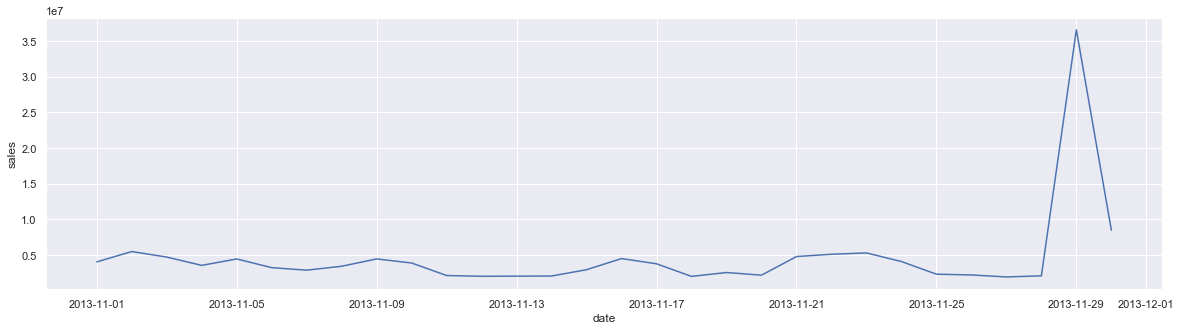

In [6]:
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='sales', data=daily, ci=None)
plt.show()

We want to understand if the sales spike is driven by specific products and/or store, or the spike happened to all variables. We will repeat the sub category extraction as we did in the exploratory analysis

In [7]:
cat_id = outlier.groupby(['date', 'item_category_name', 'item_category_id'])['sales'].sum().reset_index()
cat_id[['sub_cat', 'prod_name']] = cat_id['item_category_name'].str.split('-', n=1, expand=True)
cat_id['sub_cat'] = cat_id['sub_cat'].apply(lambda x: x.strip().lower())

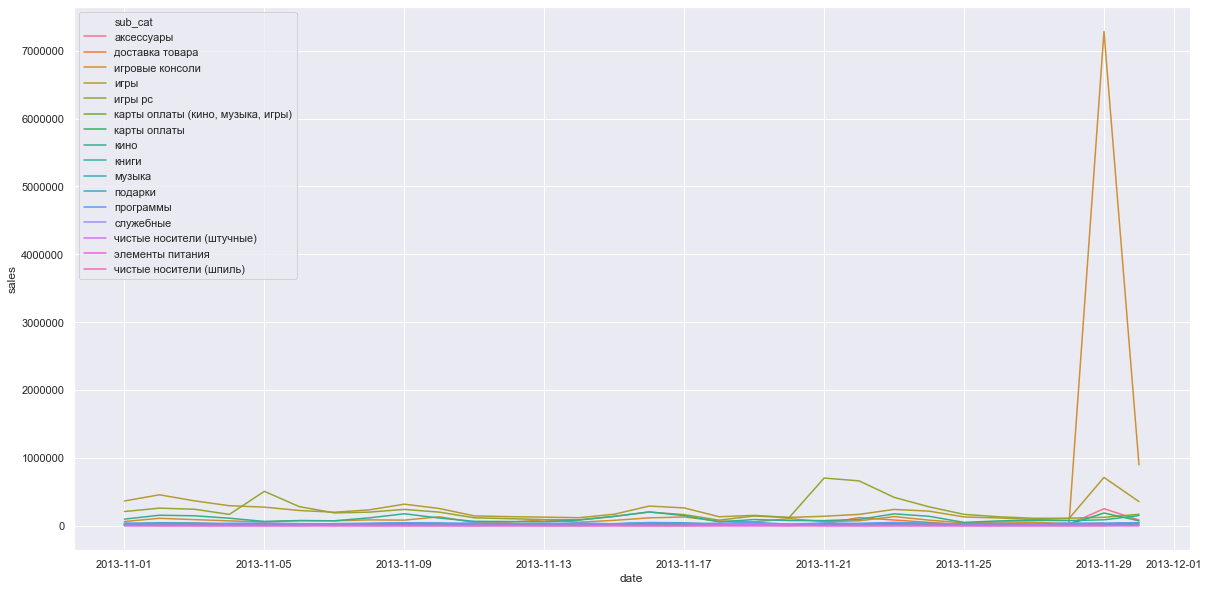

In [8]:
plt.figure(figsize = (20, 10))
sns.lineplot(x='date', y='sales', data=cat_id, hue='sub_cat', ci=None)
plt.show()

We can see that the sale split happened to a particular item_category игровые консоли.

In [9]:
cat_id_outliner = cat_id.query('sub_cat == "игровые консоли"')

Product category id as included in that category are

In [10]:
id_out = list(cat_id_outliner.item_category_id.unique())
id_out

[11, 14, 15, 12]

Now we have a list of category id that cause the sales splike, we will look at the shop level to see if that only happen in specific shops

In [11]:
shop = outlier.groupby(['date', 'item_category_id', 'shop_id'])['sales'].sum().reset_index()

In [12]:
shop.head()

,date,item_category_id,shop_id,sales
0,2013-11-01,2,15,2590.0
1,2013-11-01,2,22,3290.0
2,2013-11-01,2,25,3180.0
3,2013-11-01,2,26,2490.0
4,2013-11-01,2,27,1290.0


In [13]:
shop_outlier = shop.query('item_category_id == @id_out')

In [14]:
shop_outlier = shop_outlier.groupby(['date','shop_id'])['sales'].sum().reset_index()

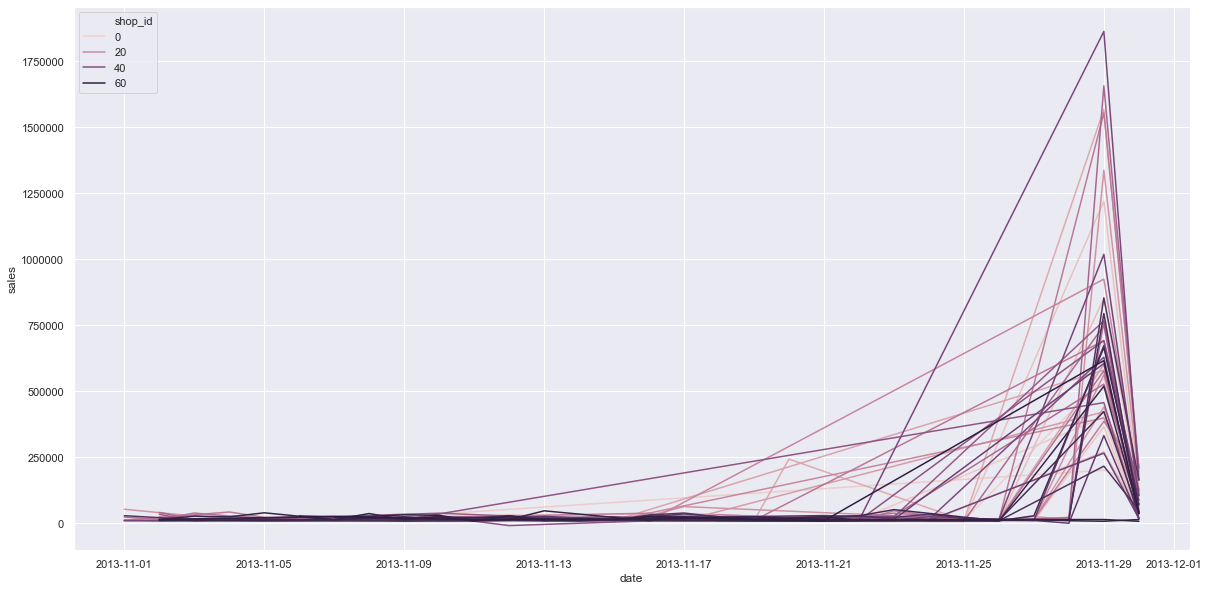

In [15]:
plt.figure(figsize = (20, 10))
sns.lineplot(x='date', y='sales', data=shop_outlier, hue='shop_id', ci=None)
plt.show()

The spike appear to happen at all shops. 

### Conclusion:

The sale spike was mainly occured at item categories 11, 12, 14, 15. It could be a result of big promotion on those items which we cannot tell from the data. We will classify them as one time event and would not factor that into the model. To replace the outlier, we replace record under 2013-10-29 for item category id 11, 12, 14, 15 with the sales average of 2013-10-28 and 2013-10-30.

In [16]:
#steps on replaceing the outlier, set the qualified values to np.nan
train_df.loc[(train_df.date == '2013-11-29') & (train_df.item_category_id.isin(id_out)), 'sales'] = np.nan

In [17]:
train_df.loc[(train_df.date == '2013-11-29') & (train_df.item_category_id.isin(id_out))].head()

,date,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_day,sales
2233359,2013-11-29,10,25,"Москва ТРК ""Атриум""",4861,Microsoft Xbox 360 4GB (RKB-00011),15,Игровые консоли - XBOX 360,7990.0,1.0,NaN
2234451,2013-11-29,10,27,"Москва ТЦ ""МЕГА Белая Дача II""",7940,Xbox 360 250 ГБ Halo4+Tomb Raider (N2V-00016),15,Игровые консоли - XBOX 360,9990.0,1.0,NaN
2234609,2013-11-29,10,12,Интернет-магазин ЧС,7940,Xbox 360 250 ГБ Halo4+Tomb Raider (N2V-00016),15,Игровые консоли - XBOX 360,10490.0,1.0,NaN
2234781,2013-11-29,10,50,"Тюмень ТЦ ""Гудвин""",7940,Xbox 360 250 ГБ Halo4+Tomb Raider (N2V-00016),15,Игровые консоли - XBOX 360,9990.0,1.0,NaN
2234806,2013-11-29,10,42,"СПб ТК ""Невский Центр""",7940,Xbox 360 250 ГБ Halo4+Tomb Raider (N2V-00016),15,Игровые консоли - XBOX 360,9990.0,1.0,NaN


In [18]:
#interploate the values by taking the average between the date before and after
train_df.loc[(train_df.date_block_num == 10) & (train_df.item_category_id.isin(id_out))].interpolate(method='linear').head()

,date,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_day,sales
2232844,2013-11-15,10,18,"Красноярск ТЦ ""Июнь""",7945,Xbox 360 320 ГБ+Halo 4 Special Edition (S4K-00...,15,Игровые консоли - XBOX 360,10490.0,1.0,10490.0
2232845,2013-11-17,10,18,"Красноярск ТЦ ""Июнь""",7945,Xbox 360 320 ГБ+Halo 4 Special Edition (S4K-00...,15,Игровые консоли - XBOX 360,10490.0,1.0,10490.0
2232884,2013-11-04,10,4,"Волжский ТЦ ""Волга Молл""",7945,Xbox 360 320 ГБ+Halo 4 Special Edition (S4K-00...,15,Игровые консоли - XBOX 360,12990.0,1.0,12990.0
2232898,2013-11-25,10,2,"Адыгея ТЦ ""Мега""",7945,Xbox 360 320 ГБ+Halo 4 Special Edition (S4K-00...,15,Игровые консоли - XBOX 360,10490.0,1.0,10490.0
2232957,2013-11-17,10,47,"Сургут ТРЦ ""Сити Молл""",7945,Xbox 360 320 ГБ+Halo 4 Special Edition (S4K-00...,15,Игровые консоли - XBOX 360,10490.0,1.0,10490.0


In [19]:
outlier_1 = train_df.query('date_block_num == 10')
daily_1 = outlier_1.groupby(['date'])['sales'].sum().reset_index()

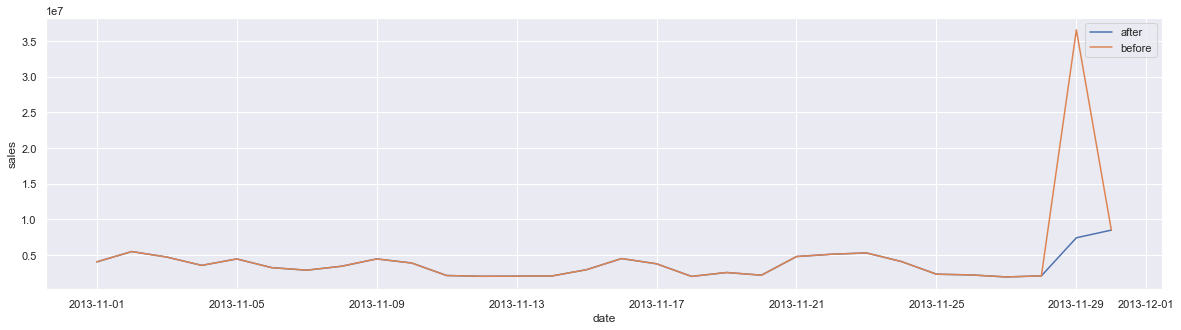

In [20]:
# Look at the before and after datafram to confirm that the outlier has been smoothed out
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='sales', data=daily_1, ci=None, label='after')
sns.lineplot(x='date',y='sales', data=daily, ci=None, label='before')
plt.show()